
**Project Repository:** https://github.com/GokulKarthik/deep-learning-projects-pytorch

### References:
[1] https://github.com/carnotaur/crnn-tutorial/

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18

import string
from tqdm.notebook import tqdm
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import multiprocessing as mp

/home/coochie/miniconda3/envs/py39/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/coochie/miniconda3/envs/py39/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [27]:
cpu_count = mp.cpu_count()
print(cpu_count)

12


## 1. Make train-test split

**Data Link**: https://www.kaggle.com/shawon10/captcha-recognition

In [28]:
data_path = "./data/samples/"

In [29]:
image_fns = os.listdir(data_path)
print(sorted(image_fns))
print(len(image_fns))
print(np.unique([len(image_fn.split(".")[0]) for image_fn in image_fns]))

['226md.png', '22d5n.png', '2356g.png', '23mdg.png', '23n88.png', '243mm.png', '244e2.png', '245y5.png', '24f6w.png', '24pew.png', '25257.png', '253dc.png', '25egp.png', '25m6p.png', '25p2m.png', '25w53.png', '264m5.png', '268g2.png', '28348.png', '28x47.png', '2b827.png', '2bg48.png', '2cegf.png', '2cg58.png', '2cgyx.png', '2en7g.png', '2enf4.png', '2fxgd.png', '2g783.png', '2g7nm.png', '2gyb6.png', '2mg87.png', '2mpnn.png', '2n73f.png', '2nbc5.jpg', '2nbcx.png', '2nf26.png', '2npg6.png', '2nx38.png', '2p2y8.png', '2pfpn.png', '2w4y7.png', '2wc38.png', '2wx73.png', '2x7bm.png', '2xc2n.png', '2ycn8.png', '2yggg.png', '325fb.png', '32cnn.png', '32dnn.png', '33b22.png', '33f7m.png', '33n73.png', '33ng4.png', '33p4e.png', '34b84.png', '34fxm.png', '34pcn.png', '368y5.png', '36bc2.png', '36nx4.png', '36w25.png', '373gb.png', '377xx.png', '378e5.png', '37d52.png', '37ep6.png', '387g2.png', '38n57.png', '3b4we.png', '3bd8f.png', '3bfnd.png', '3bnyf.png', '3bx86.png', '3c7de.jpg', '3cpwb.png'

In [30]:
for idx, image_fn in enumerate(image_fns):
    if len(image_fn.split(".")[0]) != 5:
           print(idx, image_fn)

10 samples


In [31]:
image_fns.remove('samples')
print(len(image_fns))

1070


In [32]:
image_fns_train, image_fns_test = train_test_split(image_fns, random_state=0)
print(len(image_fns_train), len(image_fns_test))

802 268


## 2. Define character maps

In [33]:
image_ns = [image_fn.split(".")[0] for image_fn in image_fns]
print(image_ns)
image_ns = "".join(image_ns)
letters = sorted(list(set(list(image_ns))))
print(len(letters))
print(letters)

['6gnm3', '3bfnd', 'd8xcn', 'nfcb5', 'n373n', 'nwfde', '8bbw8', '8b735', 'w4x2m', '6end3', '3ye2e', '7gmf3', 'y5dpp', 'f35xp', 'ncww7', '5325m', '4b2pw', 'xfn6n', 'gfp54', '8gmc4', '8w754', 'c6f8g', '5f3gf', 'n6f4b', 'pdyc8', 'egxmp', '474ff', 'bc8nf', '46mbm', '38n57', '4cn7b', 'dd5w5', 'm4fd8', 'e25xg', '87nym', '6e2dg', '3nnpw', 'pym7p', 'bw6n6', 'n7g4f', '3mxdn', 'pw5nc', 'geyn5', 'bf52c', '6wb76', 'f6ne5', '6ydyp', 'fg7mg', 'n5wbg', '62fgn', 'n464c', 'pnmxf', 'x7422', 'yf424', 'pe4xn', '5n732', '77n6g', 'edwny', 'xp24p', 'xcmbp', 'edg3p', '7634y', 'pgg3n', 'g7fmc', 'be6np', 'nfndw', '5mcy7', 'yew6p', 'g6n7x', '3xng6', '53mn8', 'y32yy', 'w4cnn', 'yyg5g', 'dfnx4', '5fyem', '36bc2', 'gy8xb', 'pmg55', '6xen4', 'n7ff2', 'cwgyx', '8n4n8', '34b84', 'y7d75', 'mc35n', 'e43ym', 'e4gd7', 'mye68', '3ebpw', '6xpme', 'nbwnn', 'y7mnm', 'mg5nn', '2g7nm', 'g842c', 'x3deb', '6cm6m', '65m85', 'c482b', 'y53c2', 'yemy4', '3ebnn', 'nnn5p', 'gp7c5', 'pg2pm', 'd7en3', 'ddxpp', 'cfc56', 'wmpmp', '8nbew', 

In [34]:
vocabulary = ["-"] + letters
print(len(vocabulary))
print(vocabulary)
idx2char = {k:v for k,v in enumerate(vocabulary, start=0)}
print(idx2char)
char2idx = {v:k for k,v in idx2char.items()}
print(char2idx)

20
['-', '2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']
{0: '-', 1: '2', 2: '3', 3: '4', 4: '5', 5: '6', 6: '7', 7: '8', 8: 'b', 9: 'c', 10: 'd', 11: 'e', 12: 'f', 13: 'g', 14: 'm', 15: 'n', 16: 'p', 17: 'w', 18: 'x', 19: 'y'}
{'-': 0, '2': 1, '3': 2, '4': 3, '5': 4, '6': 5, '7': 6, '8': 7, 'b': 8, 'c': 9, 'd': 10, 'e': 11, 'f': 12, 'g': 13, 'm': 14, 'n': 15, 'p': 16, 'w': 17, 'x': 18, 'y': 19}


## 3. Define data loader

In [35]:
batch_size = 16

In [36]:
class CAPTCHADataset(Dataset):
    
    def __init__(self, data_dir, image_fns):
        self.data_dir = data_dir
        self.image_fns = image_fns
        
    def __len__(self):
        return len(self.image_fns)
    
    def __getitem__(self, index):
        image_fn = self.image_fns[index]
        image_fp = os.path.join(self.data_dir, image_fn)
        image = Image.open(image_fp).convert('RGB')
        image = self.transform(image)
        text = image_fn.split(".")[0]
        return image, text
    
    def transform(self, image):
        
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)

In [37]:
trainset = CAPTCHADataset(data_path, image_fns_train) 
testset = CAPTCHADataset(data_path, image_fns_test)
train_loader = DataLoader(trainset, batch_size=batch_size, num_workers=cpu_count, shuffle=True)
test_loader = DataLoader(testset, batch_size=batch_size, num_workers=cpu_count, shuffle=False)
print(len(train_loader), len(test_loader))

51 17


In [52]:
dataiter = iter(train_loader)
image_batch, text_batch = next(dataiter)
print(image_batch.size(), text_batch)

torch.Size([16, 3, 50, 200]) ('y48c3', 'x3fwf', 'fbp2c', 'wm47f', '6pwcn', '6wg4n', 'p2dw7', 'mmfm6', 'f4wfn', '2fxgd', '7cdge', '84py4', 'ndg2b', 'nc4yg', 'g2577', '574d7')


## 4. Define model

In [44]:
num_chars = len(char2idx)
print(num_chars)
rnn_hidden_size = 256

20


In [45]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [46]:
resnet = resnet18(pretrained=True)
#print(resnet)

In [47]:
class CRNN(nn.Module):
    
    def __init__(self, num_chars, rnn_hidden_size=256, dropout=0.1):
        
        super(CRNN, self).__init__()
        self.num_chars = num_chars
        self.rnn_hidden_size = rnn_hidden_size
        self.dropout = dropout
        
        # CNN Part 1
        resnet_modules = list(resnet.children())[:-3]
        self.cnn_p1 = nn.Sequential(*resnet_modules)
        
        # CNN Part 2
        self.cnn_p2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=(3,6), stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.linear1 = nn.Linear(1024, 256)
        
        # RNN
        self.rnn1 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        self.rnn2 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        self.linear2 = nn.Linear(self.rnn_hidden_size*2, num_chars)
        
        
    def forward(self, batch):
        
        batch = self.cnn_p1(batch)
        # print(batch.size()) # torch.Size([-1, 256, 4, 13])
        
        batch = self.cnn_p2(batch) # [batch_size, channels, height, width]
        # print(batch.size())# torch.Size([-1, 256, 4, 10])
        
        batch = batch.permute(0, 3, 1, 2) # [batch_size, width, channels, height]
        # print(batch.size()) # torch.Size([-1, 10, 256, 4])
         
        batch_size = batch.size(0)
        T = batch.size(1)
        batch = batch.view(batch_size, T, -1) # [batch_size, T==width, num_features==channels*height]
        # print(batch.size()) # torch.Size([-1, 10, 1024])
        
        batch = self.linear1(batch)
        # print(batch.size()) # torch.Size([-1, 10, 256])
        
        batch, hidden = self.rnn1(batch)
        feature_size = batch.size(2)
        batch = batch[:, :, :feature_size//2] + batch[:, :, feature_size//2:]
        # print(batch.size()) # torch.Size([-1, 10, 256])
        
        batch, hidden = self.rnn2(batch)
        # print(batch.size()) # torch.Size([-1, 10, 512])
        
        batch = self.linear2(batch)
        # print(batch.size()) # torch.Size([-1, 10, 20])
        
        batch = batch.permute(1, 0, 2) # [T==10, batch_size, num_classes==num_features]
        # print(batch.size()) # torch.Size([10, -1, 20])
        
        return batch

In [48]:
def weights_init(m):
    classname = m.__class__.__name__
    if type(m) in [nn.Linear, nn.Conv2d, nn.Conv1d]:
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [49]:
crnn = CRNN(num_chars, rnn_hidden_size=rnn_hidden_size)
crnn.apply(weights_init)
crnn = crnn.to(device)

In [50]:
#crnn

In [53]:
text_batch_logits = crnn(image_batch.to(device))
print(text_batch)
print(text_batch_logits.shape)

('y48c3', 'x3fwf', 'fbp2c', 'wm47f', '6pwcn', '6wg4n', 'p2dw7', 'mmfm6', 'f4wfn', '2fxgd', '7cdge', '84py4', 'ndg2b', 'nc4yg', 'g2577', '574d7')
torch.Size([10, 16, 20])


## 5. Define loss

In [54]:
criterion = nn.CTCLoss(blank=0)

In [55]:
def encode_text_batch(text_batch):
    
    text_batch_targets_lens = [len(text) for text in text_batch]
    text_batch_targets_lens = torch.IntTensor(text_batch_targets_lens)
    
    text_batch_concat = "".join(text_batch)
    text_batch_targets = [char2idx[c] for c in text_batch_concat]
    text_batch_targets = torch.IntTensor(text_batch_targets)
    
    return text_batch_targets, text_batch_targets_lens

In [56]:
def compute_loss(text_batch, text_batch_logits):
    """
    text_batch: list of strings of length equal to batch size
    text_batch_logits: Tensor of size([T, batch_size, num_classes])
    """
    text_batch_logps = F.log_softmax(text_batch_logits, 2) # [T, batch_size, num_classes]  
    text_batch_logps_lens = torch.full(size=(text_batch_logps.size(1),), 
                                       fill_value=text_batch_logps.size(0), 
                                       dtype=torch.int32).to(device) # [batch_size] 
    #print(text_batch_logps.shape)
    #print(text_batch_logps_lens) 
    text_batch_targets, text_batch_targets_lens = encode_text_batch(text_batch)
    #print(text_batch_targets)
    #print(text_batch_targets_lens)
    loss = criterion(text_batch_logps, text_batch_targets, text_batch_logps_lens, text_batch_targets_lens)

    return loss

In [57]:
compute_loss(text_batch, text_batch_logits)

tensor(4.6682, grad_fn=<MeanBackward0>)

## 6. Train model

In [58]:
num_epochs = 50
lr = 0.001
weight_decay = 1e-3
clip_norm = 5

In [59]:
optimizer = optim.Adam(crnn.parameters(), lr=lr, weight_decay=weight_decay)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=5)

/home/coochie/miniconda3/envs/py39/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [60]:
crnn = CRNN(num_chars, rnn_hidden_size=rnn_hidden_size)
crnn.apply(weights_init)
crnn = crnn.to(device)

In [61]:
epoch_losses = []
iteration_losses = []
num_updates_epochs = []
for epoch in tqdm(range(1, num_epochs+1)):
    epoch_loss_list = [] 
    num_updates_epoch = 0
    for image_batch, text_batch in tqdm(train_loader, leave=False):
        optimizer.zero_grad()
        text_batch_logits = crnn(image_batch.to(device))
        loss = compute_loss(text_batch, text_batch_logits)
        iteration_loss = loss.item()

        if np.isnan(iteration_loss) or np.isinf(iteration_loss):
            continue
          
        num_updates_epoch += 1
        iteration_losses.append(iteration_loss)
        epoch_loss_list.append(iteration_loss)
        loss.backward()
        nn.utils.clip_grad_norm_(crnn.parameters(), clip_norm)
        optimizer.step()

    epoch_loss = np.mean(epoch_loss_list)
    print("Epoch:{}    Loss:{}    NumUpdates:{}".format(epoch, epoch_loss, num_updates_epoch))
    epoch_losses.append(epoch_loss)
    num_updates_epochs.append(num_updates_epoch)
    lr_scheduler.step(epoch_loss)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:1    Loss:3.026907958236395    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:2    Loss:2.3972714181039847    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:3    Loss:1.9124049976760267    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:4    Loss:1.5988108924790925    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:5    Loss:1.4120474633048563    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:6    Loss:1.2910579840342205    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:7    Loss:1.230757514635722    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:8    Loss:1.2093553356095856    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:9    Loss:1.0950986287173103    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:10    Loss:1.0170632881276749    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:11    Loss:0.9599419727044947    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:12    Loss:0.9222759510956559    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:13    Loss:0.9667693411602694    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:14    Loss:0.9089968777170369    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:15    Loss:0.8440777834723977    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:16    Loss:0.8198253477320951    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:17    Loss:0.8580491063641567    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:18    Loss:0.7832658711601707    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:19    Loss:0.7594867629163405    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:20    Loss:0.7562080189293506    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:21    Loss:0.7997036716517281    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:22    Loss:0.8553902121151195    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:23    Loss:0.7950807342342302    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:24    Loss:0.7524758916275174    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:25    Loss:0.7622672085668526    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:26    Loss:0.7842576234948402    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:27    Loss:0.7078501582145691    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:28    Loss:0.7387181076348996    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:29    Loss:0.6858433520092684    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:30    Loss:0.6768017013867696    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:31    Loss:0.6654921092239081    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:32    Loss:0.6869743653372222    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:33    Loss:0.8953077851557264    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:34    Loss:0.7605196938795202    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:35    Loss:0.695752363578946    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:36    Loss:0.7027285017219245    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:37    Loss:0.683817911381815    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:38    Loss:0.6179276284049539    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:39    Loss:0.5857458208121505    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:40    Loss:0.5746801203372431    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:41    Loss:0.5706290684494317    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:42    Loss:0.565853707930621    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:43    Loss:0.5612529142230165    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:44    Loss:0.5586255356377247    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:45    Loss:0.5561359139049754    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:46    Loss:0.5522724495214575    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:47    Loss:0.550258504409416    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:48    Loss:0.5478879517199946    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:49    Loss:0.547439810107736    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:50    Loss:0.5435480522174462    NumUpdates:51


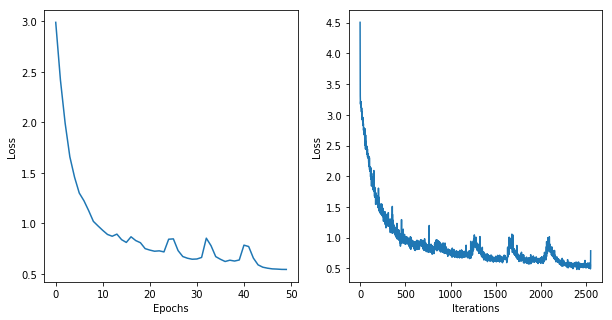

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(epoch_losses)
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

ax2.plot(iteration_losses)
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Loss")

plt.show()

## 7. Make predictions

In [ ]:
def decode_predictions(text_batch_logits):

    text_batch_tokens = F.softmax(text_batch_logits, 2).argmax(2) # [T, batch_size]
    text_batch_tokens = text_batch_tokens.numpy().T # [batch_size, T]

    text_batch_tokens_new = []
    for text_tokens in text_batch_tokens:
        text = [idx2char[idx] for idx in text_tokens]
        text = "".join(text)
        text_batch_tokens_new.append(text)

    return text_batch_tokens_new

In [ ]:
results_train = pd.DataFrame(columns=['actual', 'prediction'])
train_loader = DataLoader(trainset, batch_size=16, num_workers=1, shuffle=False)
with torch.no_grad():
    for image_batch, text_batch in tqdm(train_loader, leave=True):
        text_batch_logits = crnn(image_batch.to(device)) # [T, batch_size, num_classes==num_features]
        text_batch_pred = decode_predictions(text_batch_logits.cpu())
        #print(text_batch, text_batch_pred)
        df = pd.DataFrame(columns=['actual', 'prediction'])
        df['actual'] = text_batch
        df['prediction'] = text_batch_pred
        results_train = pd.concat([results_train, df])
results_train = results_train.reset_index(drop=True)

In [ ]:
results_test = pd.DataFrame(columns=['actual', 'prediction'])
test_loader = DataLoader(testset, batch_size=16, num_workers=1, shuffle=False)
with torch.no_grad():
    for image_batch, text_batch in tqdm(test_loader, leave=True):
        text_batch_logits = crnn(image_batch.to(device)) # [T, batch_size, num_classes==num_features]
        text_batch_pred = decode_predictions(text_batch_logits.cpu())
        #print(text_batch, text_batch_pred)
        df = pd.DataFrame(columns=['actual', 'prediction'])
        df['actual'] = text_batch
        df['prediction'] = text_batch_pred
        results_test = pd.concat([results_test, df])
results_test = results_test.reset_index(drop=True)

In [ ]:
print(results_train.shape)
results_train.head()

(802, 2)


,actual,prediction
0,pcm7f,ppccmm77ff
1,377xx,337777x-xx
2,6g45w,66gg4455ww
3,mc35n,mmcc3355nn
4,5mfff,55mmfff-ff


In [ ]:
print(results_test.shape)
results_test.head()

(268, 2)


,actual,prediction
0,2fxgd,22ffxxggdd
1,y5n6d,yy55nn66dd
2,8gmnx,88ggmmnnxx
3,wm47f,wwmmmm77ff
4,dn26n,ddnn2266nn


In [ ]:
def remove_duplicates(text):
    if len(text) > 1:
        letters = [text[0]] + [letter for idx, letter in enumerate(text[1:], start=1) if text[idx] != text[idx-1]]
    elif len(text) == 1:
        letters = [text[0]]
    else:
        return ""
    return "".join(letters)

def correct_prediction(word):
    parts = word.split("-")
    parts = [remove_duplicates(part) for part in parts]
    corrected_word = "".join(parts)
    return corrected_word

In [ ]:
results_train['prediction_corrected'] = results_train['prediction'].apply(correct_prediction)
results_train.head()

,actual,prediction,prediction_corrected
0,pcm7f,ppccmm77ff,pcm7f
1,377xx,337777x-xx,37xx
2,6g45w,66gg4455ww,6g45w
3,mc35n,mmcc3355nn,mc35n
4,5mfff,55mmfff-ff,5mff


In [ ]:
results_test['prediction_corrected'] = results_test['prediction'].apply(correct_prediction)
results_test.head()

,actual,prediction,prediction_corrected
0,2fxgd,22ffxxggdd,2fxgd
1,y5n6d,yy55nn66dd,y5n6d
2,8gmnx,88ggmmnnxx,8gmnx
3,wm47f,wwmmmm77ff,wm7f
4,dn26n,ddnn2266nn,dn26n


## 8. Evaluate the model

In [ ]:
mistakes_df = results_test[results_test['actual'] != results_test['prediction_corrected']]
mistakes_df

,actual,prediction,prediction_corrected
3,wm47f,wwmmmm77ff,wm7f
42,pmg55,ppmmgg5555,pmg5
64,mddgb,mmddddggbb,mdgb
74,mmy5n,mmmmyy55nn,my5n
77,6n6gg,66nn66gggg,6n6g
78,664nf,666644nnff,64nf
80,x775w,xx777755ww,x75w
81,55y2m,5555yy22mm,5y2m
88,f2fge,ff22ggggee,f2ge
92,d666m,dd6---66mm,d66m


In [ ]:
print(mistakes_df['prediction_corrected'].str.len().value_counts())

4    29
5     2
3     2
Name: prediction_corrected, dtype: int64


In [ ]:
mask = mistakes_df['prediction_corrected'].str.len() == 5
mistakes_df[mask]

,actual,prediction,prediction_corrected
196,mxnw4,mmxxmmww44,mxmw4
254,wgnwp,wwggmmwwpp,wgmwp


/kaggle/input/captcha-version-2-images/samples/mxnw4.png


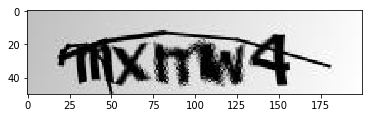

In [ ]:
mistake_image_fp = os.path.join(data_path, mistakes_df[mask]['actual'].values[0] + ".png")
print(mistake_image_fp)
mistake_image = Image.open(mistake_image_fp)
plt.imshow(mistake_image)
plt.show()

In [ ]:
train_accuracy = accuracy_score(results_train['actual'], results_train['prediction_corrected'])
print(train_accuracy)
test_accuracy = accuracy_score(results_test['actual'], results_test['prediction_corrected'])
print(test_accuracy)

0.92643391521197
0.8768656716417911
